# Classification based on TransferLearning


We train a CNN based on a [dataset](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=no) with 3k brain mri images. Then we try transfer learning

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD, RMSprop, lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

from data import get_img_dataset
from project3Lib.transforms import EnhanceContrast
import project3Lib.CNN as cnn
from masked_dataset import MaskedDataset
import project3Lib.utils as utils
from pathlib import Path

import shap

/Users/noraschneider/opt/anaconda3/envs/BrainMRI/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import TransferLearning Dataset
transferlearning_path = "data/tl_dataset"
transform = [EnhanceContrast(reduce_dim=False), transforms.Grayscale()]
tl_train_dataset,tl_val_dataset, tl_test_dataset = get_img_dataset(transform, data_path=transferlearning_path, use_same_transforms = True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)
batch_size = 64
tl_trainloader = DataLoader(tl_train_dataset, batch_size=batch_size, shuffle=True)
tl_testloader = DataLoader(tl_test_dataset, batch_size=batch_size, shuffle=False)
tl_validloader = DataLoader(tl_val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {
    'train' : tl_trainloader, 
    'validation': tl_validloader
}

image_datasets = {
    'train': tl_train_dataset,
    'validation': tl_val_dataset
}

Loaded samples into dataset with label 'no'=0 and 'yes'=1
Device state: cpu


In [3]:
def train_model(model, criterion, optimizer, dataloaders, image_datasets, patience = 0, num_epochs=3):
    last_loss = 200
    triggertimes = 0
    best_model = model
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            # Early stopping
            if phase == 'train' or patience <= 0:
                continue
            
            if epoch_loss > last_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    return best_model
            else:
                trigger_times = 0
                best_model = model

            last_loss = epoch_loss
            
    return best_model

def test(model, test_dataset):
    x_test = [i for i,j in test_dataset]
    y_test = [j for i,j in test_dataset]
    preds = []
    outs = []
    for t in x_test:
        pred, out = predict(model, t)
        preds.append(pred)

    return accuracy_score(preds,y_test), f1_score(preds,y_test)

def predict(model, x):
    out = model(x.reshape(1, 1, 128, 128))   
    _,prediction = torch.max(out, dim=1)
    return prediction[0].item(), out

Train model on large dataset

In [6]:
model = cnn.CNN()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

epochs = 30
model = train_model(model, criterion, optimizer, dataloaders, image_datasets, num_epochs=epochs)

Epoch 1/30
----------
train loss: 0.6904, acc: 0.5254
validation loss: 0.6879, acc: 0.4933
Epoch 2/30
----------
train loss: 0.6001, acc: 0.6900
validation loss: 0.5209, acc: 0.7767
Epoch 3/30
----------
train loss: 0.4788, acc: 0.8242
validation loss: 0.4737, acc: 0.8300
Epoch 4/30
----------
train loss: 0.4484, acc: 0.8588
validation loss: 0.5437, acc: 0.7567
Epoch 5/30
----------
train loss: 0.4453, acc: 0.8658
validation loss: 0.4534, acc: 0.8433
Epoch 6/30
----------
train loss: 0.4153, acc: 0.8983
validation loss: 0.4292, acc: 0.8700
Epoch 7/30
----------
train loss: 0.4219, acc: 0.8846
validation loss: 0.4217, acc: 0.8867
Epoch 8/30
----------
train loss: 0.4071, acc: 0.9046
validation loss: 0.3954, acc: 0.9167
Epoch 9/30
----------
train loss: 0.4017, acc: 0.9108
validation loss: 0.4024, acc: 0.9067
Epoch 10/30
----------
train loss: 0.3884, acc: 0.9258
validation loss: 0.3935, acc: 0.9200
Epoch 11/30
----------
train loss: 0.3865, acc: 0.9258
validation loss: 0.3937, acc: 0.91

In [6]:
torch.save(model.state_dict(), f"trained_weights/TL_basemodel.pt")

SHAP analysis for Large Dataset

In [5]:
model = cnn.CNN()
model.load_state_dict(torch.load("trained_weights/TL_basemodel.pt"))

<All keys matched successfully>

Mean values 0.4699663539159779, 0.5300336475585471


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


Image #0: True Class 1, Prediction 1, Probabilities tensor([[4.1586e-19, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


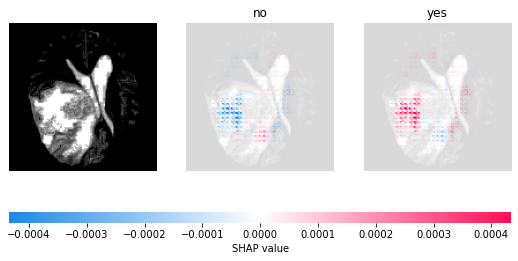

Image #1: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 4.3451e-10]], grad_fn=<SoftmaxBackward0>)


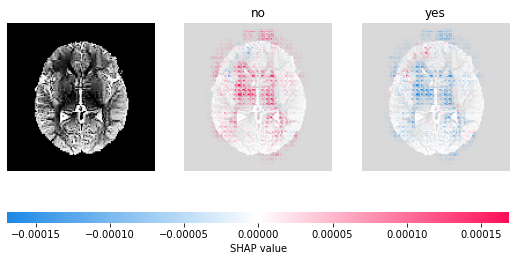

Image #2: True Class 1, Prediction 1, Probabilities tensor([[7.2416e-32, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


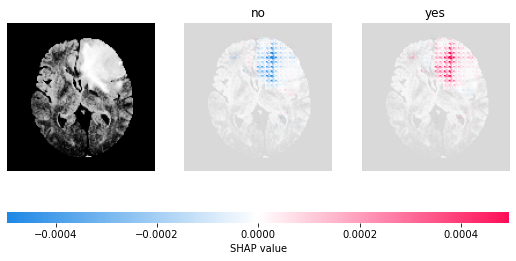

Image #3: True Class 1, Prediction 1, Probabilities tensor([[0., 1.]], grad_fn=<SoftmaxBackward0>)


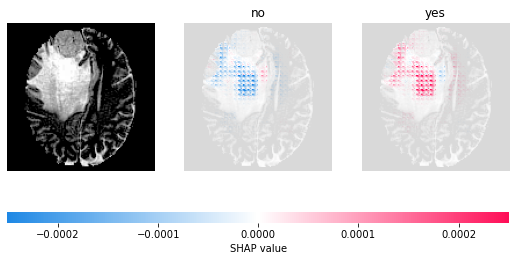

Image #4: True Class 0, Prediction 0, Probabilities tensor([[0.8063, 0.1937]], grad_fn=<SoftmaxBackward0>)


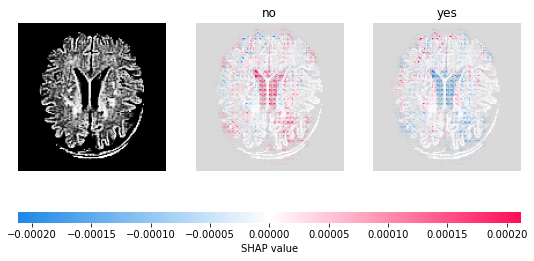

Image #5: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 4.0794e-07]], grad_fn=<SoftmaxBackward0>)


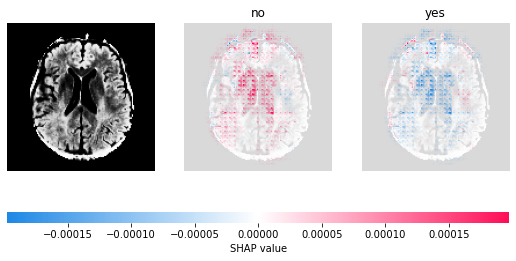

Image #6: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 1.5319e-09]], grad_fn=<SoftmaxBackward0>)


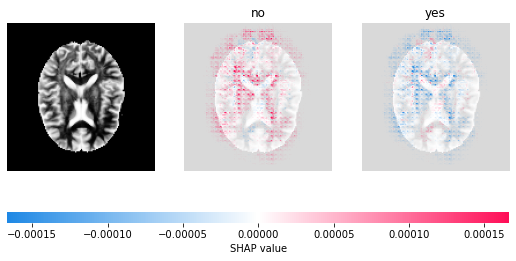

Image #7: True Class 1, Prediction 1, Probabilities tensor([[7.3489e-05, 9.9993e-01]], grad_fn=<SoftmaxBackward0>)


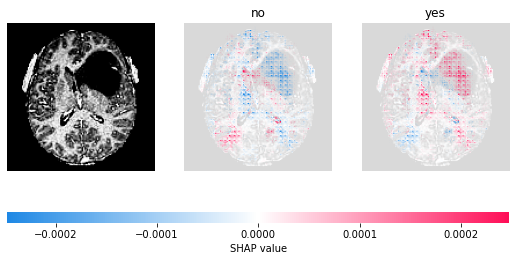

Image #8: True Class 1, Prediction 1, Probabilities tensor([[7.5670e-44, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


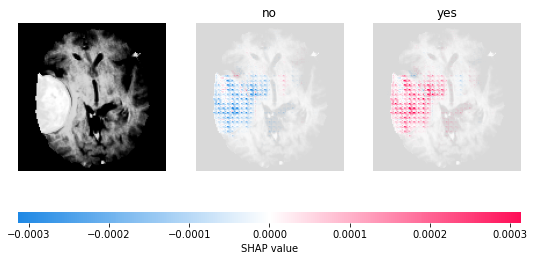

Image #9: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 3.1537e-09]], grad_fn=<SoftmaxBackward0>)


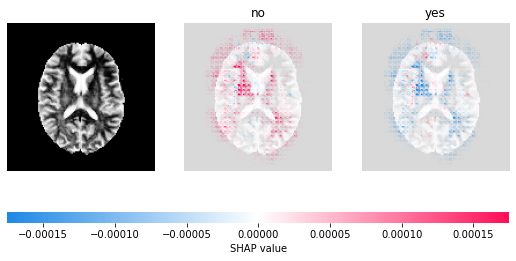

In [9]:
# Deep Explainer
np.random.seed(123)
indices = np.random.randint(0, high=len(tl_train_dataset), size=100)
bg = torch.utils.data.Subset(tl_train_dataset, indices)
bg = [i for i,j in bg]
bg = torch.stack(bg)

e = shap.DeepExplainer(model, bg)

outs = []
for i in bg:
    pred, out = predict(model,i)
    outs.append((out[0][0].item(), out[0][1].item()))
print(f"Mean values {np.mean([i for i,j in outs])}, {np.mean([j for i,j in outs])}")


indices = np.random.randint(0, high=len(tl_test_dataset), size=10)
sub_test = torch.utils.data.Subset(tl_test_dataset, indices)

test_images = [i for i,j in sub_test]
y_test = [j for i,j in sub_test]

for i, image in enumerate(test_images):
    
    image = image.reshape((1,1,128,128))
    pred, out = predict(model,image)
    shap_values = e.shap_values(image)
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(image.cpu().numpy(), 1, -1), 1, 2)
    print(f"Image #{i}: True Class {y_test[i]}, Prediction {pred}, Probabilities {out}")
    shap.image_plot(shap_numpy, test_numpy, labels = ["no","yes"])

This is so nice! Now let's transfer some knowledge yay!

# Transfer

In [6]:
unique = input("Use unique images?[yes/no]").lower() == "yes"
input_path = "data/unique_images" if unique else "data/images"

transform = [EnhanceContrast(reduce_dim=False), transforms.Grayscale()]
train_dataset,val_dataset, test_dataset = get_img_dataset(transform, data_path=input_path, use_same_transforms = True)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)
batch_size = 16
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {
    'train' : trainloader, 
    'validation': validloader
}

image_datasets = {
    'train': train_dataset,
    'validation': val_dataset
}

full_retrain = input("Retrain all layers? [yes/no]").lower() == "yes"

Use unique images?[yes/no]yes
Loaded samples into dataset with label 'no'=0 and 'yes'=1
Device state: cpu
Retrain all layers? [yes/no]yes


In [11]:
transfer_model = cnn.CNN()
transfer_model.load_state_dict(torch.load("trained_weights/TL_basemodel.pt"))
if not full_retrain:
    for param in transfer_model.parameters():
        param.requires_grad = False
    for layer in transfer_model.modules():
        if isinstance(layer, nn.Linear):
            layer.weight.requires_grad = True

total_trainable_params = sum(
    p.numel() for p in transfer_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

294,818 training parameters.


In [14]:
criterion = CrossEntropyLoss()
optimizer = Adam(transfer_model.parameters(), lr=0.0005)
epochs = 20
transfer_model = train_model(transfer_model, criterion, optimizer, dataloaders, image_datasets, num_epochs=epochs)

Epoch 1/20
----------
train loss: 0.3487, acc: 0.9620
validation loss: 0.4632, acc: 0.8500
Epoch 2/20
----------
train loss: 0.3386, acc: 0.9747
validation loss: 0.4628, acc: 0.8500
Epoch 3/20
----------
train loss: 0.3397, acc: 0.9747
validation loss: 0.4608, acc: 0.8500
Epoch 4/20
----------
train loss: 0.3403, acc: 0.9747
validation loss: 0.4626, acc: 0.8500
Epoch 5/20
----------
train loss: 0.3340, acc: 0.9810
validation loss: 0.4634, acc: 0.8500
Epoch 6/20
----------
train loss: 0.3324, acc: 0.9810
validation loss: 0.4470, acc: 0.8500
Epoch 7/20
----------
train loss: 0.3333, acc: 0.9810
validation loss: 0.4341, acc: 0.8500
Epoch 8/20
----------
train loss: 0.3388, acc: 0.9684
validation loss: 0.4417, acc: 0.8500
Epoch 9/20
----------
train loss: 0.3380, acc: 0.9747
validation loss: 0.4637, acc: 0.8500
Epoch 10/20
----------
train loss: 0.3429, acc: 0.9684
validation loss: 0.4141, acc: 0.9000
Epoch 11/20
----------
train loss: 0.3361, acc: 0.9747
validation loss: 0.4199, acc: 0.90

In [17]:
torch.save(transfer_model.state_dict(), f"trained_weights/TL_model.pt")

# Evaluate

In [4]:
transfer_model = cnn.CNN()
transfer_model.load_state_dict(torch.load("trained_weights/TL_model.pt"))

<All keys matched successfully>

In [7]:
x_test = [i for i,j in test_dataset]
y_test = [j for i,j in test_dataset]
preds = []
outs = []
for t in x_test:
    pred, out = predict(transfer_model, t)
    preds.append(pred)
    
print(f"Accuracy: {accuracy_score(preds,y_test)}")
print(f"F1 score: {f1_score(preds,y_test)}")

Accuracy: 0.95
F1 score: 0.9565217391304348


```
Accuracy: 0.95
F1 score: 0.9565217391304348
```

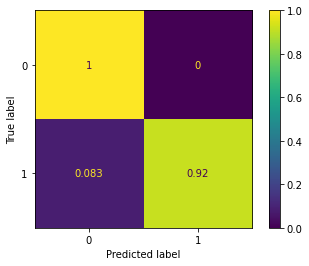

In [8]:
cm=confusion_matrix(y_test,preds,normalize="true")
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

# SHAP

In [9]:
transform = [transforms.Grayscale()]
common_transform = [EnhanceContrast(reduce_dim=False)]
_,_, test_dataset = get_img_dataset(transform = transform, \
                                    use_same_transforms=True, \
                                    common_transforms=common_transform, \
                                    data_path=input_path, \
                                    folder_type = MaskedDataset, \
                                    mask_folder=Path("data/masks"))

Loaded samples into dataset with label 'no'=0 and 'yes'=1


In [10]:
# Deep Explainer
bg = [i for i,j in train_dataset]
bg = torch.stack(bg)
e = shap.DeepExplainer(transfer_model, bg)
outs = []
for i in bg:
    pred, out = predict(transfer_model,i)
    outs.append((out[0][0].item(), out[0][1].item()))
print(f"Mean values {np.mean([i for i,j in outs])}, {np.mean([j for i,j in outs])}")

Mean values 0.4556974236207898, 0.5443025763527766


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


Image #0: True Class 1, Prediction 1, Probabilities tensor([[2.7467e-09, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


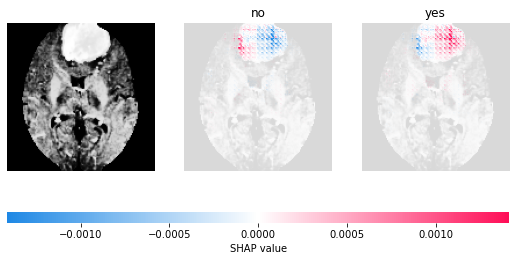

0.1378988617279343
Image #1: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 5.2291e-12]], grad_fn=<SoftmaxBackward0>)


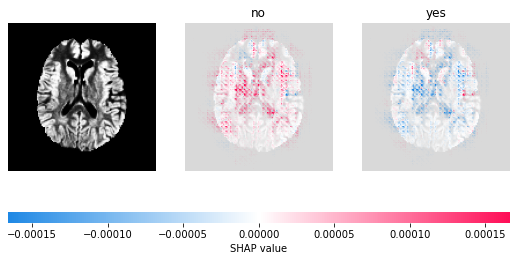

0.0
Image #2: True Class 1, Prediction 0, Probabilities tensor([[1.0000e+00, 3.4126e-11]], grad_fn=<SoftmaxBackward0>)


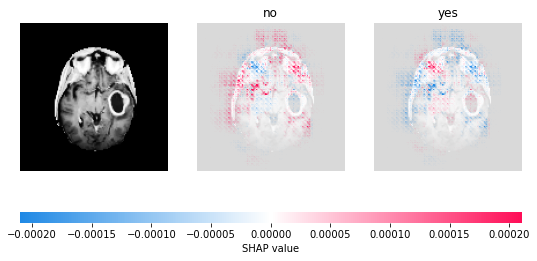

0.03424930306650737
Image #3: True Class 1, Prediction 1, Probabilities tensor([[1.4380e-09, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


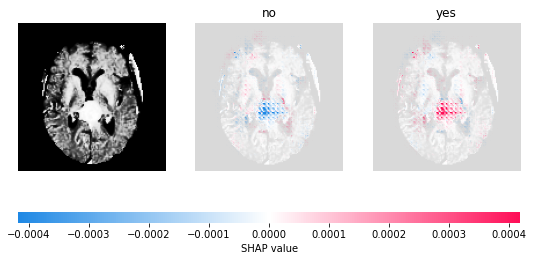

0.05575684380032206
Image #4: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 2.5380e-14]], grad_fn=<SoftmaxBackward0>)


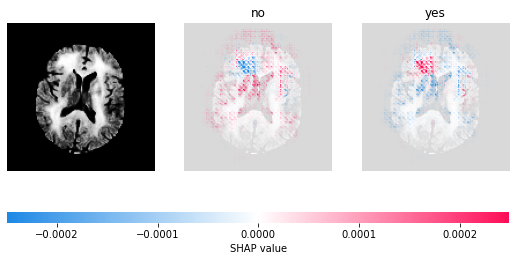

0.0
Image #5: True Class 1, Prediction 1, Probabilities tensor([[7.8955e-18, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


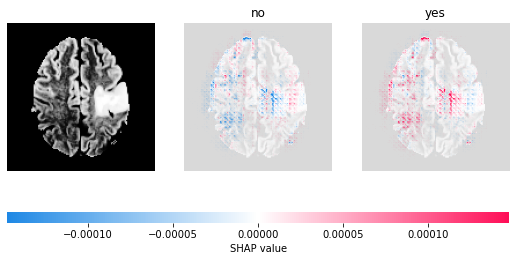

0.06392344497607655
Image #6: True Class 1, Prediction 1, Probabilities tensor([[1.2582e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


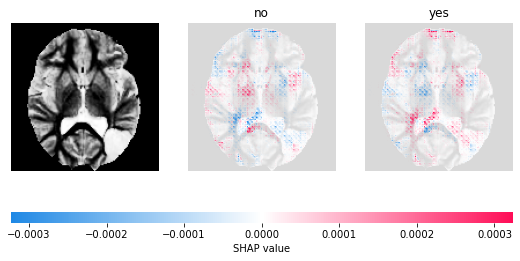

0.05665831566775872
Image #7: True Class 1, Prediction 1, Probabilities tensor([[1.2289e-14, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


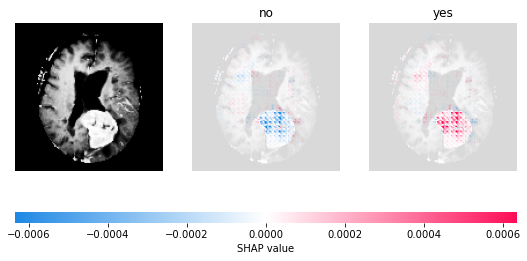

0.11602538675128918
Image #8: True Class 1, Prediction 1, Probabilities tensor([[2.4187e-35, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


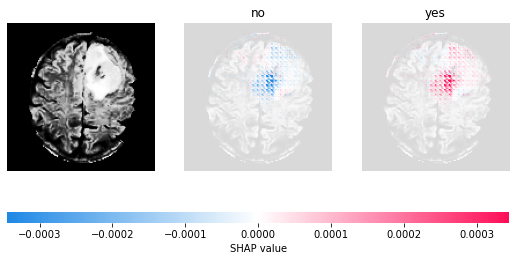

0.15279907975460122
Image #9: True Class 1, Prediction 1, Probabilities tensor([[6.8899e-32, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


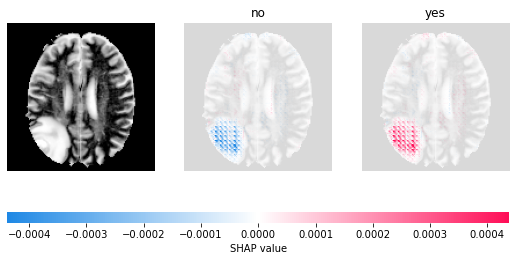

0.14960170973382553
Image #10: True Class 1, Prediction 1, Probabilities tensor([[1.2573e-12, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


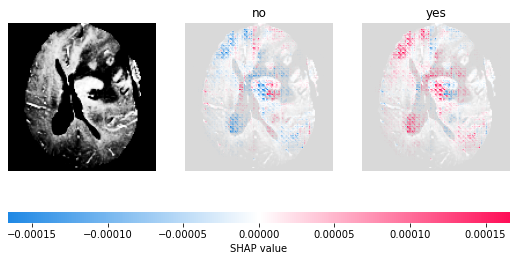

0.19744483159117304
Image #11: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 4.7412e-13]], grad_fn=<SoftmaxBackward0>)


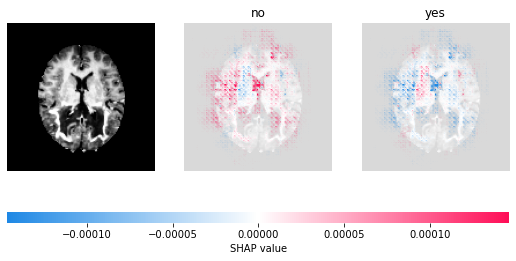

0.0
Image #12: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 2.2360e-06]], grad_fn=<SoftmaxBackward0>)


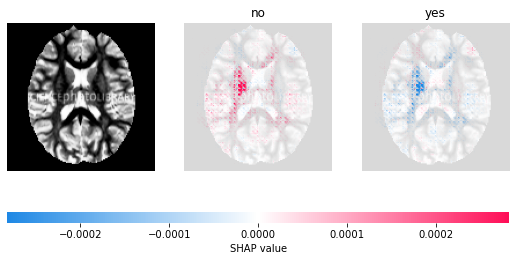

0.0
Image #13: True Class 1, Prediction 1, Probabilities tensor([[0.0490, 0.9510]], grad_fn=<SoftmaxBackward0>)


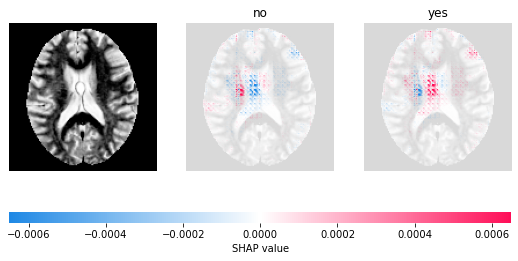

0.048095488853782696
Image #14: True Class 1, Prediction 1, Probabilities tensor([[2.7426e-13, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


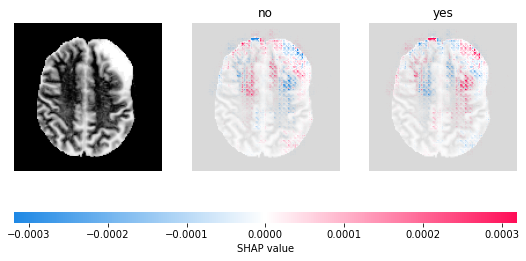

0.05943201053225503
Image #15: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 6.5149e-10]], grad_fn=<SoftmaxBackward0>)


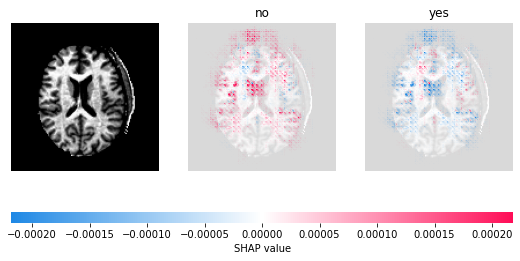

0.0
Image #16: True Class 1, Prediction 1, Probabilities tensor([[4.7837e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


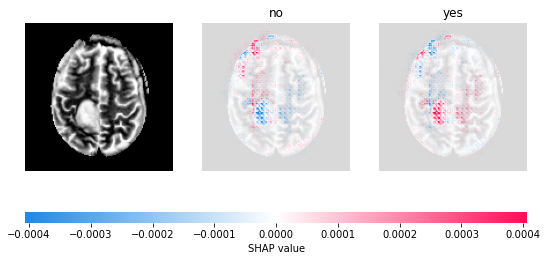

0.06724511930585683
Image #17: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 2.6407e-07]], grad_fn=<SoftmaxBackward0>)


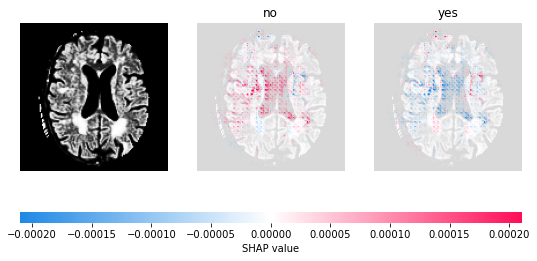

0.0
Image #18: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 1.2542e-07]], grad_fn=<SoftmaxBackward0>)


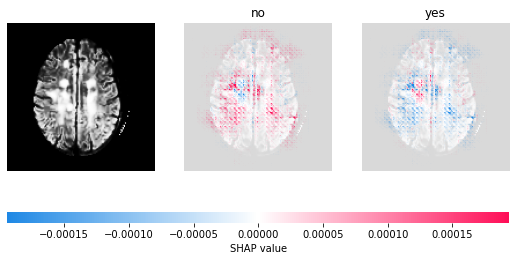

0.0
Image #19: True Class 0, Prediction 0, Probabilities tensor([[1.0000e+00, 2.9343e-10]], grad_fn=<SoftmaxBackward0>)


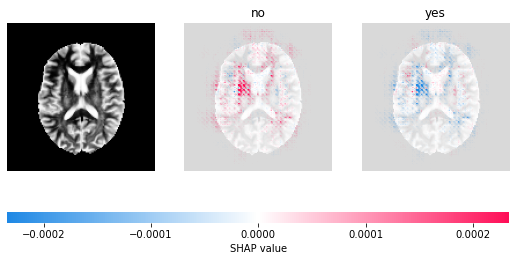

0.0


In [11]:
ious = []
for i, (image,mask,target) in enumerate(test_dataset):
    image = image.reshape((1,1,128,128))
    pred, out = predict(transfer_model,image)
    
    shap_values = e.shap_values(image)
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(image.cpu().numpy(), 1, -1), 1, 2)
    print(f"Image #{i}: True Class {target}, Prediction {pred}, Probabilities {out}")
    shap.image_plot(shap_numpy, test_numpy, labels = ["no","yes"])
    
    predicted_mask = np.copy(shap_values[1].reshape(128,128))
    mask = mask.numpy().reshape((128,128))
    iou = utils.evaluate_interpretability(predicted_mask, mask)
    print(iou)
    ious.append(iou)